# OWPHydroTools Demonstration
## Python-based Tools for Retrieving and Evaluating National Water Model Streamflow Simulations
### AGU Fall Meeting 2021 - Poster H450-1343

*Jason A. Regina<sup>1</sup> & Arthur A. Raney<sup>2</sup>*

<sup>1</sup>Office of Water Prediction, NOAA/NWS, Tuscaloosa, AL, USA

<sup>2</sup>Consortium of Universities for the Advancement of Hydrologic Science, Inc., Cambridge, MA, USA (Formerly NOAA Pathways Intern, National Water Center)

#### Abstract
The OWPHydroTools suite (https://github.com/NOAA-OWP/hydrotools) includes packages used to:
 - Asynchronously retrieve USGS streamflow observations as Pandas DataFrames
 - Efficiently retrieve National Water Model (NWM) streamflow simulations and forecasts from Google Cloud Platform as Pandas DataFrames
 - Generate evaluation metrics such as Nash-Sutcliffe Efficiency and Threat Score
 - Detect hydrological events in long streamflow time series and compute single-event metrics from hydrograph features

This set of python packages includes efficient algorithms suitable for use in enterprise evaluation of continental-scale hydrologic and hydraulic model outputs. We showcase the capability of these tools through an example evaluation at Little Hope Creek in Charlotte, North Carolina, USA. We demonstrate the utility of this tool set in an event-based evaluation of the NWM “open loop” simulation at Little Hope Creek that includes peak discharge error, volume error, timing errors, NNSE, and categorical statistics.

<sup><sub>Presented at the AGU Fall Meeting, 13-17, Dec., 2021, New Orleans, LA
Session H074 - Next generation water resources modeling: innovation at the intersection of domain, computer, and data sciences</sup></sub>

In [ ]:
# Import National Water Model client tool
from hydrotools.nwm_client import gcp as nwm

# Import USGS NWIS IV client tool
from hydrotools.nwis_client.iv import IVDataService

# Import basic evaluation metrics
from hydrotools.metrics import metrics

# Import event detection tools
from hydrotools.events.event_detection import decomposition as ev

# Additional imports
import pandas as pd
from pathlib import Path
import dask.dataframe as dd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
plt.style.use('tableau-colorblind10')

In [2]:
# Retrieve simulations
def get_sim():
    # Set up client
    model_client = nwm.NWMDataService()

    # Generate list of references times
    reference_dts = pd.date_range(
        start="2021-07-01 16:00",
        periods=31,
        freq="24H"
    )

    # Retrieval paramteters
    configuration="analysis_assim_extend_no_da"
    reference_times = [d.strftime("%Y%m%dT%-HZ") for d in reference_dts]

    # Retrieve model data
    dfs = []
    for rt in reference_times:
        # Retrieve single simulation
        try:
            df = model_client.get(
                configuration=configuration,
                reference_time=rt
            )
        except ValueError as e:
            # Ignore missing simulation
            continue

        # Store single simluation
        dfs.append(df)

    # Concatenate simulations
    sim = pd.concat(dfs, ignore_index=True)

    # Keep "best" simulations
    sim = sim.sort_values(by=["usgs_site_code", "reference_time", "value_time"])
    sim = sim.drop_duplicates(subset=["usgs_site_code", "value_time"], keep="last")

    # Drop extra columns
    sim = sim[["usgs_site_code", "value_time", "value"]]

    # Convert to cubic feet per second
    cms_to_cfs = 0.3048 ** (-3.0)
    sim["value"] = sim["value"].mul(cms_to_cfs)

    # Drop NWIS IV incompatible locations
    mask = sim["usgs_site_code"].str.contains(r"[a-zA-Z]")
    return sim[~mask]

In [3]:
# Retrieve observations to match simulations
def get_obs(sim):
    # Set directory to store observations
    odir = Path("observations")
    odir.mkdir(exist_ok=True)

    # Chunk USGS sites
    chunks = np.array_split(sim["usgs_site_code"].astype(str).unique(), 10)

    # Setup USGS NWIS IV client
    obs_client = IVDataService(value_time_label="value_time")

    # Retrieve observations in chunks
    for c, site_list in enumerate(chunks):
        # Check for chunk
        ofile = odir / f"part.{c}.h5"
        if ofile.exists():
            continue

        # Retrieve observations
        df = obs_client.get(
            sites=site_list,
            startDT=sim["value_time"].min(),
            endDT=sim["value_time"].max()
        )

        # Drop extra columns
        df = df[[
            'usgs_site_code', 
            'value_time', 
            'value'
            ]]

        # Check for duplicate time series, keep first by default
        df = df.drop_duplicates(
            subset=['usgs_site_code', 'value_time']
            )

        # Resample to hourly, keep first measurement in each 1-hour bin
        df = df.groupby([
            'usgs_site_code',
            pd.Grouper(key='value_time', freq='H')
            ]).first()

        # Save chunk
        df.to_hdf(ofile, key="data", format="table", complevel=1)

    # Load observations
    return dd.read_hdf("observations/*.h5", key="data").compute()

In [4]:
# Pair observations with simulations
def get_pairs():
    # Get simulations
    sim = get_sim()
    
    # Get observations
    obs = get_obs(sim)
    
    # Index simulation data
    sim = sim.set_index(["usgs_site_code", "value_time"])

    # Pair observations with simulations
    sim = sim.rename(columns={"value": "sim"})
    obs = obs.rename(columns={"value": "obs"})
    
    # Ignore negative values
    sim[sim < 0.0] = np.nan
    obs[obs < 0.0] = np.nan
    
    return pd.concat([obs, sim], axis=1)

In [5]:
# Retrieve and pair data
pairs = get_pairs()

# Sort multi-index to avoid performance warnings
pairs = pairs.reset_index().sort_values(by=["usgs_site_code", "value_time"])
pairs = pairs.set_index(["usgs_site_code", "value_time"])
pairs.style.format("{:.2f}")

obs         sim
usgs_site_code  value_time                             
01010000        2021-06-30 12:00:00  1230.0         NaN
                2021-06-30 13:00:00  1230.0  344.671143
                2021-06-30 14:00:00  1210.0  352.440369
                2021-06-30 15:00:00  1180.0  357.737579
                2021-06-30 16:00:00  1170.0  364.447357
...                                     ...         ...
480608115242901 2021-07-31 12:00:00     NaN    0.706293
                2021-07-31 13:00:00     NaN    0.706293
                2021-07-31 14:00:00     NaN    0.706293
                2021-07-31 15:00:00     NaN    0.706293
                2021-07-31 16:00:00     NaN    0.706293

[5691398 rows x 2 columns]

In [6]:
# Work with a subset of data
#  Forward fill missing data
df = pairs.loc[("02146470",),:].ffill()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
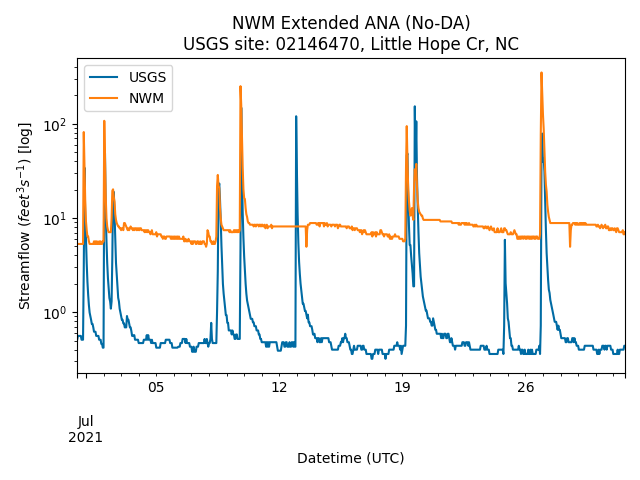

In [42]:
# Plot
fig, ax = plt.subplots()
df.plot(ax=ax, logy=True)
ax.set_title("NWM Extended ANA (No-DA)\nUSGS site: 02146470, Little Hope Cr, NC")
ax.set_xlabel("Datetime (UTC)")
ax.set_ylabel(r"Streamflow ($feet^3 s^{-1}$) [log]")
ax.legend(["USGS", "NWM"])
fig.tight_layout()
plt.show(fig)

In [18]:
# Daily maximum flows
daily_max = df.resample("1D").max()

# Apply flow exceedance criteria to forecasts (10.0 CFS)
criteria = 10.0
daily_max['simulated_flow_ex'] = (daily_max['sim'] >= criteria)
daily_max['observed_flow_ex'] = (daily_max['obs'] >= criteria)

# Convert boolean columns to Categoricals
daily_max['simulated_flow_ex'] = daily_max['simulated_flow_ex'].astype('category')
daily_max['observed_flow_ex'] = daily_max['observed_flow_ex'].astype('category')

# Compute contingency table
contingency_table = metrics.compute_contingency_table(
    daily_max['observed_flow_ex'],
    daily_max['simulated_flow_ex']
)

In [19]:
# Print pretty version of continengency table
pretty_ct = contingency_table.to_frame(name="Count")
pretty_ct.index.name = "Contingency Table"
pretty_ct = pretty_ct.rename(index={
    "true_positive": "True Positives",
    "false_positive": "False Positives",
    "false_negative": "False Negatives",
    "true_negative": "True Negatives",
})
pretty_ct

,Count
Contingency Table,
True Positives,7
False Positives,2
False Negatives,2
True Negatives,21


In [28]:
# Compute suite of categorical verification metrics
metrics_suite = pd.DataFrame.from_dict({
    "POD": metrics.probability_of_detection(contingency_table),
    "POFD": metrics.probability_of_false_detection(contingency_table),
    "POFA": metrics.probability_of_false_alarm(contingency_table),
    "FBI": metrics.frequency_bias(contingency_table),
    "CSI": metrics.threat_score(contingency_table),
    "ETS": metrics.equitable_threat_score(contingency_table),
    "NNSE": metrics.nash_sutcliffe_efficiency(df["obs"], df["sim"], normalized=True)
}, orient="index", columns=["Value"])
metrics_suite.index.name = "Metric"
metrics_suite.style.format('{:.3f}')

,Value
Metric,
POD,0.778
POFD,0.087
POFA,0.222
FBI,1.000
CSI,0.636
ETS,0.528
NNSE,0.268


In [81]:
# Mark observed "event" flow
df["obs_ev"] = ev.mark_event_flows(df["obs"], halflife='12H', window='7D', start_radius='12H',
    minimum_event_duration='1D')
df.loc[df["obs_ev"], "ev_flow"] = df.loc[df["obs_ev"], "obs"]
df.loc[~df["obs_ev"], "nev_flow"] = df.loc[~df["obs_ev"], "obs"]

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
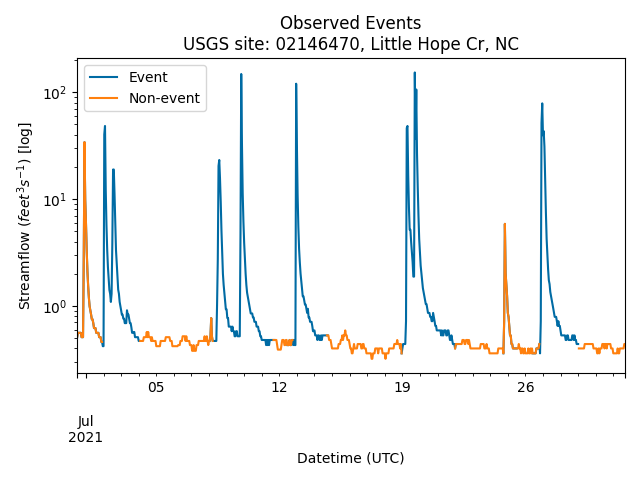

In [82]:
# Plot observed events
fig, ax = plt.subplots()
df[["ev_flow", "nev_flow"]].plot(ax=ax, logy=True)
ax.set_title("Observed Events\nUSGS site: 02146470, Little Hope Cr, NC")
ax.set_xlabel("Datetime (UTC)")
ax.set_ylabel(r"Streamflow ($feet^3 s^{-1}$) [log]")
ax.legend(["Event", "Non-event"])
fig.tight_layout()
plt.show(fig)

In [60]:
# Characterize event flows
def characterize_events(events, values):
    # Event duration
    events["duration"] = events["end"].sub(events["start"])
    
    # Compute peak flows in cubic feet per second
    events['peak'] = events.apply(
        lambda e: values.loc[e.start:e.end].max(),
        axis=1
        )
    
    # Find time of peak
    events['time_of_peak'] = events.apply(
        lambda e: values.loc[e.start:e.end].idxmax(),
        axis=1
        )
    
    # Compute total volume in ac-ft
    #  Assumes hourly discharge values in cubic feet per second
    #  Conversion: (3600 seconds per hour) * (1 acre per 43,560 square feet)
    #  Reduced conversion factor: 10/121
    events['volume'] = events.apply(
        lambda e: values.loc[e.start:e.end].sum() * (10.0/121.0),
        axis=1
        )
    return events

In [83]:
# Detect observed events
#  This particular algorithm is suited for flashy rainfall-driven runoff "events"
obs_events = ev.list_events(df["obs"], halflife='12H', window='7D', start_radius='12H',
    minimum_event_duration='1D')
obs_events = characterize_events(obs_events, df["obs"])

# Drop first event (erroneous baseflow in obs)
# obs_events = obs_events.iloc[1:]
obs_events

,start,end,duration,peak,time_of_peak,volume
0,2021-07-01 23:00:00,2021-07-04 01:00:00,2 days 02:00:00,48.299999,2021-07-02 02:00:00,17.229753
1,2021-07-08 01:00:00,2021-07-11 17:00:00,3 days 16:00:00,148.000000,2021-07-09 20:00:00,28.260329
2,2021-07-12 11:00:00,2021-07-14 16:00:00,2 days 05:00:00,120.000000,2021-07-12 23:00:00,17.201654
3,2021-07-18 23:00:00,2021-07-22 02:00:00,3 days 03:00:00,153.000000,2021-07-19 17:00:00,44.227275
4,2021-07-26 10:00:00,2021-07-29 00:00:00,2 days 14:00:00,78.599998,2021-07-26 23:00:00,25.497525


In [84]:
# Detect simulated events
sim_events = ev.list_events(df["sim"], halflife='12H', window='7D', start_radius='12H',
    minimum_event_duration='1D')
sim_events = characterize_events(sim_events, df["sim"])
sim_events

,start,end,duration,peak,time_of_peak,volume
0,2021-07-01 14:00:00,2021-07-03 10:00:00,1 days 20:00:00,107.356583,2021-07-02 01:00:00,42.669456
1,2021-07-09 07:00:00,2021-07-11 13:00:00,2 days 06:00:00,250.380981,2021-07-09 19:00:00,79.822821
2,2021-07-19 01:00:00,2021-07-21 07:00:00,2 days 06:00:00,94.290154,2021-07-19 06:00:00,64.558716
3,2021-07-26 12:00:00,2021-07-28 21:00:00,2 days 09:00:00,349.968353,2021-07-26 22:00:00,113.707386


In [86]:
# Evaluate simulated events
for e in sim_events.itertuples():
    # Find matching observed event
    comparison = obs_events.loc[obs_events["start"] <= e.end, :]
    comparison = comparison.loc[comparison["end"] >= e.start, :]
    
    # Check for no event
    if comparison.empty:
        continue
    
    # Extract observed values
    obs_pk = comparison["peak"].iloc[0]
    obs_pk_tm = comparison["time_of_peak"].iloc[0]
    obs_vol = comparison["volume"].iloc[0]
    
    # Compute errors
    peak_error = 100 * (e.peak - obs_pk) / obs_pk
    peak_time_error = (e.time_of_peak - obs_pk_tm) / pd.Timedelta("1H")
    volume_error = 100 * (e.volume - obs_vol) / obs_vol
    
    print(peak_error)
    print(peak_time_error)
    print(volume_error)
    # print(comparison)
    # print(e)
    # break
    

122.2703609469769
-1.0
147.6498406712579
69.17633881440034
-1.0
182.45538583297105
-38.37244869057649
-11.0
45.97036826842648
345.2523664955424
-1.0
345.9546064452694
